# Visualizations

## Imports

In [916]:
import pandas as pd
import altair as alt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from ast import literal_eval
import wordcloud
import matplotlib.pyplot as plt

import ipywidgets as widgets
import plotly.subplots as sp
import matplotlib
import ipywidgets as widgets
from IPython.display import clear_output, display
from sklearn import preprocessing
import numpy as np

## Globals

In [917]:
# True when the song should be removed when he contains one of the genres
# False when only the genres of the aritst should be removed
REMOVE_ARTIST = True
NOTEBOOK = False
FONT_SIZE = 18

In [918]:
if NOTEBOOK:
    FIG_HEIGHT = 500
    FIG_WIDTH = 1000
else: 
    FIG_HEIGHT = 1200
    FIG_WIDTH = 2000

## Preprocessing

In [919]:
remove_genres = ["classical", "jazz", "folk", "french", "turkish", "gospel", "samba", "piano", "mpb", "sertanejo", "pagode", "sleep", "forro", "malay", "anime", 
                 "j-idol", "comedy", "mandopop", "cantopop", "show-tunes", "emo", "romance", "j-dance", "chill", "world-music", "iranian", "idm", "metalcore", 
                 "hardstyle", "opera", "k-pop", "j-pop", "j-rock", "happy"]

In [920]:
by_isrc = pd.read_csv('data/checkpoint/by_isrc.csv')

In [921]:
by_isrc.shape

(416154, 25)

In [922]:
by_isrc = by_isrc[~by_isrc["name"].isna()]

In [923]:
by_isrc.shape

(416152, 25)

#### Adapt chart power

In [924]:
chart_power = pd.read_excel('docker/chart-power-scores_80s.xlsx')

In [925]:
chart_power_df = chart_power.copy()
chart_power_df = chart_power_df.applymap(lambda s: s.lower() if type(s) == str else str(s))
chart_power_df['Points'] = chart_power_df['Points'].astype(int)
chart_power_df = chart_power_df[['Song', 'Artist', 'Points']].groupby(['Song', 'Artist']).sum()
chart_power_df.reset_index(inplace=True)

In [926]:
chart_power_df.head(2)

,Song,Artist,Points
0,'cause you're young,c. c. catch,998
1,(carmen) danger in her eyes,deborah sasson & mcl,531


In [927]:
chart_power_df.sort_values('Points', ascending=False)

,Song,Artist,Points
297,dance little bird,electronica's,4071
1504,sun of jamaica,goombay dance band,3255
1039,maid of orleans (the waltz of joan of arc),o.m.d.,3254
40,adios amor,andy borg,3233
869,johnny and mary,robert palmer,3157
...,...,...,...
1464,stars on 45 vol. iii,stars on 45,410
1430,solomon gundie,amanda lear,406
1355,"say hello, wave goodbye",soft cell,405
430,du hast es gut,milva,404


If multilple artists created one song they are connected by an '&'.

In [928]:
chart_power_df['Artist'] = chart_power_df['Artist'].apply(lambda x: x.split(' & '))
chart_power_df_explode = chart_power_df.explode('Artist')

In [929]:
print(chart_power_df.shape)
print(chart_power_df_explode.shape)

(1894, 3)
(2027, 3)


In [930]:
chart_power_df_explode.rename(columns={"Song": "name_cp", "Artist": "artists"}, inplace=True)

Now the isrc DataFrame has to be exploded aswell.

In [931]:
isrc_chart_power = by_isrc.copy()
isrc_chart_power = isrc_chart_power[['isrc', 'name', 'artists']]
print(isrc_chart_power.shape)
isrc_chart_power['artists'] = isrc_chart_power['artists'].apply(lambda x: x.split(','))
isrc_chart_power = isrc_chart_power.explode('artists')
print(isrc_chart_power.shape)
isrc_chart_power = isrc_chart_power.merge(chart_power_df_explode, how='left', on='artists')

(416152, 3)
(682184, 3)


In [932]:
isrc_chart_power[isrc_chart_power.name == 'sweet dreams (are made of this) - remastered']

,isrc,name,artists,name_cp,Points
274108,GBARL0300589,sweet dreams (are made of this) - remastered,eurythmics,here comes the rain again,990.0
274109,GBARL0300589,sweet dreams (are made of this) - remastered,eurythmics,it's alright (baby's coming back),569.0
274110,GBARL0300589,sweet dreams (are made of this) - remastered,eurythmics,love is a stranger,1534.0
274111,GBARL0300589,sweet dreams (are made of this) - remastered,eurythmics,sexcrime (nineteen eighty-four),921.0
274112,GBARL0300589,sweet dreams (are made of this) - remastered,eurythmics,sweet dreams (are made of this),1830.0
274113,GBARL0300589,sweet dreams (are made of this) - remastered,eurythmics,there must be an angel (playing with my heart),1074.0
274114,GBARL0300589,sweet dreams (are made of this) - remastered,eurythmics,thorn in my side,717.0
274115,GBARL0300589,sweet dreams (are made of this) - remastered,eurythmics,when tomorrow comes,737.0
274116,GBARL0300589,sweet dreams (are made of this) - remastered,eurythmics,who's that girl?,675.0
274117,GBARL0300589,sweet dreams (are made of this) - remastered,annie lennox,put a little love in your heart,739.0


In [933]:
def check_name(row):
    if row['name_cp'] not in row['name']:
    #if row['name_cp'] != row['name']:
        return np.nan
    else:
        return row['Points']

# Apply the check_name function row-wise to update the 'Points' column
isrc_chart_power['Points'] = isrc_chart_power[~isrc_chart_power['name_cp'].isna()].apply(check_name, axis=1)

In [934]:
isrc_chart_power[isrc_chart_power.name == 'sweet dreams (are made of this) - remastered']

,isrc,name,artists,name_cp,Points
274108,GBARL0300589,sweet dreams (are made of this) - remastered,eurythmics,here comes the rain again,NaN
274109,GBARL0300589,sweet dreams (are made of this) - remastered,eurythmics,it's alright (baby's coming back),NaN
274110,GBARL0300589,sweet dreams (are made of this) - remastered,eurythmics,love is a stranger,NaN
274111,GBARL0300589,sweet dreams (are made of this) - remastered,eurythmics,sexcrime (nineteen eighty-four),NaN
274112,GBARL0300589,sweet dreams (are made of this) - remastered,eurythmics,sweet dreams (are made of this),1830.0
274113,GBARL0300589,sweet dreams (are made of this) - remastered,eurythmics,there must be an angel (playing with my heart),NaN
274114,GBARL0300589,sweet dreams (are made of this) - remastered,eurythmics,thorn in my side,NaN
274115,GBARL0300589,sweet dreams (are made of this) - remastered,eurythmics,when tomorrow comes,NaN
274116,GBARL0300589,sweet dreams (are made of this) - remastered,eurythmics,who's that girl?,NaN
274117,GBARL0300589,sweet dreams (are made of this) - remastered,annie lennox,put a little love in your heart,NaN


In [935]:
isrc_chart_power = isrc_chart_power.sort_values('Points', ascending=False)

In [936]:
isrc_chart_power.drop_duplicates(subset='isrc', keep='first', inplace=True)

In [937]:
isrc_chart_power[isrc_chart_power.name == 'sweet dreams (are made of this) - remastered']

,isrc,name,artists,name_cp,Points
274112,GBARL0300589,sweet dreams (are made of this) - remastered,eurythmics,sweet dreams (are made of this),1830.0


In [938]:
isrc_chart_power.rename(columns={'Points': 'chart_power'}, inplace=True)

In [939]:
#isrc_chart_power.drop(columns=['name','artists', 'name_cp'],inplace=True)

In [940]:
isrc_chart_power.sort_values('chart_power', ascending=False)

,isrc,name,artists,name_cp,chart_power
139805,DEK897900010,sun of jamaica,goombay dance band,sun of jamaica,3255.0
710289,USUM70739431,johnny and mary - alternate take,robert palmer,johnny and mary,3157.0
646031,USIR28000057,johnny and mary,robert palmer,johnny and mary,3157.0
19018,BGA261068707,felicita - live,al bano,felicita,2983.0
198525,FR58F7900130,d.i.s.c.o. (version française) - version single,ottawan,d.i.s.c.o.,2737.0
...,...,...,...,...,...
738849,ved049201554,la ultima carta,aditus,NaN,NaN
738850,ved049201555,la vida no me alcanzara,aditus,NaN,NaN
738851,ved049201619,ana,aditus,NaN,NaN
738852,ved049201677,sapo lipon,serenata guayanesa,NaN,NaN


In [941]:
isrc_chart_power[~isrc_chart_power["chart_power"].isna()]

,isrc,name,artists,name_cp,chart_power
139805,DEK897900010,sun of jamaica,goombay dance band,sun of jamaica,3255.0
646031,USIR28000057,johnny and mary,robert palmer,johnny and mary,3157.0
710289,USUM70739431,johnny and mary - alternate take,robert palmer,johnny and mary,3157.0
19018,BGA261068707,felicita - live,al bano,felicita,2983.0
198533,FR58F8000020,d.i.s.c.o. (version française),ottawan,d.i.s.c.o.,2737.0
...,...,...,...,...,...
642198,USGF18100301,harden my heart,quarterflash,harden my heart,411.0
364569,GBF088100775,"say hello, wave goodbye - 7"" single version",soft cell,"say hello, wave goodbye",405.0
242827,GB4978100007,"say hello, wave goodbye",soft cell,"say hello, wave goodbye",405.0
138836,DEF088202450,du hast es gut - live in germany,milva,du hast es gut,404.0


In [942]:
'''
# Check for duplicate artists with contained names
duplicates = []
checked_indices = set()

for i, row1 in isrc_chart_power.iterrows():
    if i not in checked_indices:
        for j, row2 in isrc_chart_power.iterrows():
            if i != j and row1['artists'] == row2['artists']:
                if row1['name'] in row2['name']:
                    duplicates.append(j)
                    checked_indices.add(j)

# Remove second occurrences of duplicated rows
isrc_chart_power.drop(duplicates, inplace=True)
'''

"\n# Check for duplicate artists with contained names\nduplicates = []\nchecked_indices = set()\n\nfor i, row1 in isrc_chart_power.iterrows():\n    if i not in checked_indices:\n        for j, row2 in isrc_chart_power.iterrows():\n            if i != j and row1['artists'] == row2['artists']:\n                if row1['name'] in row2['name']:\n                    duplicates.append(j)\n                    checked_indices.add(j)\n\n# Remove second occurrences of duplicated rows\nisrc_chart_power.drop(duplicates, inplace=True)\n"

In [943]:
'''
# Check for duplicate artists with contained names
duplicates = []
for i, row1 in isrc_chart_power.iterrows():
    for j, row2 in isrc_chart_power.iterrows():
        if i != j and row1['artists'] == row2['artists']:
            if row1['name'] in row2['name']:
                duplicates.append(j)+

# Remove second occurrences of duplicated rows
isrc_chart_power.drop(duplicates, inplace=True)
'''

"\n# Check for duplicate artists with contained names\nduplicates = []\nfor i, row1 in isrc_chart_power.iterrows():\n    for j, row2 in isrc_chart_power.iterrows():\n        if i != j and row1['artists'] == row2['artists']:\n            if row1['name'] in row2['name']:\n                duplicates.append(j)+\n\n# Remove second occurrences of duplicated rows\nisrc_chart_power.drop(duplicates, inplace=True)\n"

In [944]:
import pandas as pd

# Example DataFrame
df = pd.DataFrame({
    'Artist': ['John', 'Mary', 'John', 'Peter', 'Paul', 'John'],
    'Name': ['John Doe', 'Mary Smith', 'John Smith', 'Peter Parker', 'Paul Johnson', 'John']
})

# Check for duplicate artists with contained names
duplicates = []
for i, row1 in df.iterrows():
    for j, row2 in df.iterrows():
        if i != j and row1['Artist'] == row2['Artist']:
            if row1['Name'] in row2['Name']:
                duplicates.append(j)

# Remove second occurrences of duplicated rows
df.drop(duplicates, inplace=True)
print(duplicates)
df


[0, 2]


,Artist,Name
1,Mary,Mary Smith
3,Peter,Peter Parker
4,Paul,Paul Johnson
5,John,John


In [945]:
#by_isrc.drop(columns='chart_power',inplace=True)
#by_isrc = by_isrc.merge(isrc_chart_power, how='left', on='isrc')

### Find the biggest genres

In [946]:
by_isrc_sub = by_isrc.copy()
by_isrc_sub = by_isrc_sub[['isrc', 'genres', 'year']]
by_isrc_sub.shape

(416152, 3)

In [947]:
if REMOVE_ARTIST:
    by_isrc_sub = by_isrc_sub[~by_isrc_sub['genres'].str.contains('|'.join(remove_genres))]
    by_isrc_sub['genres'] = by_isrc_sub['genres'].apply(literal_eval)
    df = by_isrc_sub.copy()
    df.drop(columns='year', inplace=True)
    by_isrc_sub = by_isrc_sub.explode('genres')
else:
    by_isrc_sub['genres'] = by_isrc_sub['genres'].apply(literal_eval)
    by_isrc_sub = by_isrc_sub.explode('genres')
    by_isrc_sub = by_isrc_sub[~by_isrc_sub['genres'].str.fullmatch('|'.join(remove_genres))]
    df = pd.DataFrame(by_isrc_sub.groupby('isrc')['genres'].apply(list))
by_isrc_sub.shape

(404094, 3)

In [948]:
df = df.merge(by_isrc.drop(columns='genres'), how='left', on='isrc')

In [949]:
df.head()

,isrc,genres,name,artists,album,release_date,release_date_precision,uri,spotify_id,chart_power,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year
0,AEA0Q1900049,[pop],asi jina sohneyan,akram rahi,"Ja Ni Tun Khushiyan Maaney, Vol. 100",1989-12-02,day,spotify:track:4gEJ7dAwc67EMzojM8yZW8,4gEJ7dAwc67EMzojM8yZW8,NaN,...,1,0.0718,0.773,0.000004,0.3660,0.857,106.167,326430,4,1989
1,AEA0Q1900050,[pop],oh na ro dil merey tun,akram rahi,"Ja Ni Tun Khushiyan Maaney, Vol. 100",1989-12-02,day,spotify:track:1sfQm4tPUxutEyX89xBNKd,1sfQm4tPUxutEyX89xBNKd,NaN,...,1,0.0746,0.819,0.000000,0.1260,0.847,127.191,383388,4,1989
2,AEA0Q1900051,[pop],nazaraan tun dur ho kay,akram rahi,"Ja Ni Tun Khushiyan Maaney, Vol. 100",1989-12-02,day,spotify:track:4lynOHGcyNVvReUJ8ivLXr,4lynOHGcyNVvReUJ8ivLXr,NaN,...,1,0.0373,0.677,0.000001,0.0769,0.965,118.307,389803,4,1989
3,AEA0Q1900052,[pop],koyi raawan ch beh (mahiye),akram rahi,"Ja Ni Tun Khushiyan Maaney, Vol. 100",1989-12-02,day,spotify:track:5GIYaE4QwbbTxDdI0KfoiX,5GIYaE4QwbbTxDdI0KfoiX,NaN,...,1,0.0502,0.735,0.001930,0.2080,0.791,110.104,724500,4,1989
4,AEA0Q1900053,[pop],ja ni tun khushiyan maaney,akram rahi,"Ja Ni Tun Khushiyan Maaney, Vol. 100",1989-12-02,day,spotify:track:0T2eReINvdY0aiAko9Tss7,0T2eReINvdY0aiAko9Tss7,NaN,...,1,0.0436,0.777,0.000000,0.1400,0.929,124.521,421667,4,1989


In [950]:
by_isrc_sub['count'] = 0

In [951]:
top_genres = pd.DataFrame(by_isrc_sub.groupby('genres')['count'].count()).sort_values(by='count', ascending=False)[:20]

In [952]:
top_genres

,count
genres,
pop,92995
rock,75732
punk,21592
metal,14063
country,13476
hard-rock,10377
german,10214
punk-rock,8794
disco,8650


In [953]:
top_genres_per_year = pd.crosstab(by_isrc_sub['year'],by_isrc_sub['genres'])

In [954]:
top_genres_per_year[list(top_genres.index)]

genres,pop,rock,punk,metal,country,hard-rock,german,punk-rock,disco,blues,swedish,soul,alternative,alt-rock,synth-pop,british,funk,hardcore,spanish,r-n-b
year,,,,,,,,,,,,,,,,,,,,
1980,9140,6667,2003,694,1340,885,584,907,1263,933,774,1031,516,466,420,553,775,359,295,264
1981,8338,6662,2200,686,1421,805,611,920,1086,806,903,1039,553,533,617,459,739,466,148,302
1982,8666,7031,2271,735,1818,1001,807,807,1170,774,774,1058,417,406,658,732,696,564,441,476
1983,7722,6826,2165,1004,1133,1010,695,838,1127,710,809,772,490,459,673,433,715,569,403,259
1984,9524,6970,2135,1399,982,1099,823,878,766,711,739,663,643,619,833,513,540,613,597,461
1985,9051,7210,2017,1431,1203,1001,815,755,798,458,760,550,652,607,816,332,596,608,686,531
1986,8811,7274,2056,1598,1240,1036,1080,853,603,638,669,542,887,844,724,530,347,529,634,425
1987,9118,8672,2010,2097,1414,1288,1292,905,583,816,795,572,1186,1164,714,727,430,638,756,621
1988,10602,8696,2395,2081,1466,1103,1714,926,618,1059,845,677,1186,1039,533,842,574,814,792,514


## Development of features over the years

In [955]:
'''
# currently not used
save = df.copy()
df['year_month'] = 0
for index, song in df.iterrows():
    df.loc[index,'year_month'] = song['year']
    if song['release_date_precision'] == 'month':
        df.loc[index,'year_month'] += int(song['release_date'][5:7]) / 12
'''

"\n# currently not used\nsave = df.copy()\ndf['year_month'] = 0\nfor index, song in df.iterrows():\n    df.loc[index,'year_month'] = song['year']\n    if song['release_date_precision'] == 'month':\n        df.loc[index,'year_month'] += int(song['release_date'][5:7]) / 12\n"

In [956]:
'''
per_year_features = ['year', 'popularity', 'danceability', 'energy',
                     'key', 'loudness', 'mode', 'speechiness',
                     'acousticness', 'instrumentalness', 'liveness',
                     'valence', 'tempo', 'duration_ms',
                     'time_signature']
per_year_agg = {
    "popularity": 'mean',
    'danceability': 'mean', 
    'energy': 'mean',
    'key': 'mean', 
    'loudness': 'mean', 
    'mode': 'mean', 
    'speechiness': 'mean',
    'acousticness': 'mean', 
    'instrumentalness': 'mean', 
    'liveness': 'mean',
    'valence': 'mean', 
    'tempo': 'mean', 
    'duration_ms': 'mean',
    'time_signature': 'mean',
    'count': 'count'
}

songs_per_year = df.copy()
songs_per_year = songs_per_year[per_year_features]
songs_per_year['count'] = -1
songs_per_year = songs_per_year.groupby("year").agg(per_year_agg)
songs_per_year.reset_index(inplace=True)
songs_per_year['duration_min'] = songs_per_year['duration_ms'] / (1000 * 60)
songs_per_year = songs_per_year.astype({'year': str})
'''

'\nper_year_features = [\'year\', \'popularity\', \'danceability\', \'energy\',\n                     \'key\', \'loudness\', \'mode\', \'speechiness\',\n                     \'acousticness\', \'instrumentalness\', \'liveness\',\n                     \'valence\', \'tempo\', \'duration_ms\',\n                     \'time_signature\']\nper_year_agg = {\n    "popularity": \'mean\',\n    \'danceability\': \'mean\', \n    \'energy\': \'mean\',\n    \'key\': \'mean\', \n    \'loudness\': \'mean\', \n    \'mode\': \'mean\', \n    \'speechiness\': \'mean\',\n    \'acousticness\': \'mean\', \n    \'instrumentalness\': \'mean\', \n    \'liveness\': \'mean\',\n    \'valence\': \'mean\', \n    \'tempo\': \'mean\', \n    \'duration_ms\': \'mean\',\n    \'time_signature\': \'mean\',\n    \'count\': \'count\'\n}\n\nsongs_per_year = df.copy()\nsongs_per_year = songs_per_year[per_year_features]\nsongs_per_year[\'count\'] = -1\nsongs_per_year = songs_per_year.groupby("year").agg(per_year_agg)\nsongs_per_y

In [957]:
def group_songs_by_year(data_frame, genre=None):
    per_year_features = ['year', 'popularity', 'danceability', 'energy',
                     'key', 'loudness', 'mode', 'speechiness',
                     'acousticness', 'instrumentalness', 'liveness',
                     'valence', 'tempo', 'duration_ms',
                     'time_signature']
    per_year_agg = {
        "popularity": 'mean',
        'danceability': 'mean', 
        'energy': 'mean',
        'key': 'mean', 
        'loudness': 'mean', 
        'mode': 'mean', 
        'speechiness': 'mean',
        'acousticness': 'mean', 
        'instrumentalness': 'mean', 
        'liveness': 'mean',
        'valence': 'mean', 
        'tempo': 'mean', 
        'duration_ms': 'mean',
        'time_signature': 'mean',
        'count': 'count'
    }
    df = data_frame.copy()
    if genre:
        df = df.explode('genres')
        df = df[df["genres"] == genre]
    df = df[per_year_features]
    df['count'] = -1
    df = df.groupby("year").agg(per_year_agg)
    df.reset_index(inplace=True)
    df['duration_min'] = df['duration_ms'] / (1000 * 60)
    df = df.astype({'year': str})

    pct_df = pd.DataFrame()
    for feature in df.columns:
        if feature != "year":
            pct_df[feature] = round(df[feature].pct_change() * 100,2)
        else:
            pct_df[feature] = df[feature]
    pct_df = pct_df.fillna(0)
    pct_df.set_index("year", inplace=True)
    pct_df = pct_df.applymap(lambda x: str(x) + '%' if x < 0 else '+' + str(x) + '%')
    return df, pct_df

In [958]:
songs_per_year, songs_per_year_pct = group_songs_by_year(df)
songs_per_year_rock, songs_per_year_rock_pct = group_songs_by_year(df, "rock")
songs_per_year_pop, songs_per_year_pop_pct = group_songs_by_year(df, "pop")

In [959]:
songs_per_year_pct

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,count,duration_min
year,,,,,,,,,,,,,,,,
1980,+0.0%,+0.0%,+0.0%,+0.0%,+0.0%,+0.0%,+0.0%,+0.0%,+0.0%,+0.0%,+0.0%,+0.0%,+0.0%,+0.0%,+0.0%,+0.0%
1981,+2.32%,+1.35%,+1.27%,+0.82%,+0.36%,-0.38%,+3.71%,-4.34%,+7.45%,-0.14%,-0.26%,+0.46%,-2.29%,+0.3%,-6.58%,-2.29%
1982,+0.21%,+1.1%,-1.12%,+0.85%,+0.83%,-0.63%,-0.25%,+2.46%,-4.0%,-0.53%,-0.06%,-0.87%,+1.86%,-0.11%,+10.38%,+1.86%
1983,+5.04%,-0.73%,+2.07%,-0.09%,-0.18%,-1.77%,-0.95%,-8.16%,+13.69%,-0.57%,-2.44%,+0.29%,+1.86%,+0.31%,-9.81%,+1.86%
1984,+2.41%,-0.68%,+0.59%,+0.82%,+0.65%,-3.13%,-4.43%,+1.88%,-7.2%,+1.09%,-1.53%,-0.25%,-1.09%,-0.03%,+12.04%,-1.09%
1985,-0.73%,-0.44%,+1.17%,-0.45%,+0.01%,+2.33%,-5.27%,-1.36%,-0.54%,-1.05%,-0.16%,-0.3%,+2.68%,-0.03%,-4.86%,+2.68%
1986,-0.4%,-1.71%,-1.21%,-0.17%,+3.31%,+0.46%,+7.9%,+1.78%,+6.14%,-3.11%,-2.63%,-0.3%,-0.19%,-0.25%,+5.6%,-0.19%
1987,+0.37%,+0.07%,+0.55%,-0.02%,+1.26%,+1.6%,+0.35%,-3.0%,+8.13%,+0.22%,-1.01%,+0.12%,-1.17%,+0.09%,+13.21%,-1.17%
1988,-4.82%,+0.58%,-0.19%,+0.44%,+1.54%,-1.01%,-1.24%,-0.91%,+1.14%,+0.7%,+1.87%,-0.55%,+0.19%,-0.17%,+11.73%,+0.19%


In [960]:
if not NOTEBOOK:
    features = ["danceability", "energy", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence"]
    spys = [
        {"title": "Development of features for all genres", "data": songs_per_year, "pct": songs_per_year_pct},
        {"title": "Development of features for genre rock", "data": songs_per_year_rock, "pct": songs_per_year_rock_pct},
        {"title": "Development of features for genre pop", "data": songs_per_year_pop, "pct": songs_per_year_pop_pct}
    ]
    
    for spy in spys:
        fig = go.Figure()
        
        for feature in features:
            fig.add_trace(go.Scatter(
            x=spy['data']['year'],
            y=spy['data'][feature],
            name=feature,
            mode="markers+text+lines",
            text=spy['pct'][feature],
            textposition='top center'
        ))
        
        fig.update_layout(
            height = FIG_HEIGHT,
            width = FIG_WIDTH,
            #yaxis_title='Popularity',
            xaxis_title='year',
            title=spy["title"],
            template='plotly_dark',
            yaxis_range=[0,1]
        )
        
        fig.show()

In [961]:
if not NOTEBOOK:
    features = [
        {
            "title": "Tempo (bpm)",
            "value": "tempo",
            "range": [110, 130]
        },
        {
            "title": "Duration (min)",
            "value": "duration_min",
            "range": [3, 5]
        },
        {
            "title": "Loudnes (dB)",
            "value": "loudness",
            "range": [0, -20]
        },
        {
            "title": "Songs released",
            "value": "count",
            "range": [0, 50000]
        }
    ]
    for feature in features:
        fig = go.Figure()
        
        fig.add_trace(go.Scatter(
            x=songs_per_year['year'],
            y=songs_per_year[feature["value"]],
            #name=feature["value"]
            name='all',
            #mode="markers+text+lines",
            #text=songs_per_year_pct[feature["value"]],
            #textposition='top center'
        ))

        fig.add_trace(go.Scatter(
            x=songs_per_year_rock['year'],
            y=songs_per_year_rock[feature["value"]],
            #name=feature["value"]
            name='rock',
            #mode="markers+text+lines",
            #text=songs_per_year_rock_pct[feature["value"]],
            #textposition='top center'
        ))

        fig.add_trace(go.Scatter(
            x=songs_per_year_pop['year'],
            y=songs_per_year_pop[feature["value"]],
            #name=feature["value"]
            name='pop',
            #mode="markers+text+lines",
            #text=songs_per_year_pop_pct[feature["value"]],
            #textposition='bottom center'
        ))
        
        fig.update_layout(
            font_size=FONT_SIZE,
            height = FIG_HEIGHT,
            width = FIG_WIDTH,
            yaxis_title=feature["title"],
            xaxis_title='year',
            title='Development of features',
            template='plotly_dark',
            yaxis_range=feature["range"]
        )
        
        fig.show()

In [962]:
if NOTEBOOK:
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(
        x=songs_per_year['year'],
        y=songs_per_year['popularity'],
        name='Duration (ms)'
    ))
    
    #fig.add_trace(go.Scatter(
    #    x=df['year_month'],
    #    y=df['duration_ms'],
    #    mode='markers',
    #    name='Duration (ms) - markers'
    #))
    
    # Define the dropdown menu options
    dropdown_options = [
        #{'label': 'Duration (ms)', 'value': 'duration_ms', 'range': []},
        {'label': 'Popularity', 'value': 'popularity', 'range': [0,10]},
        {'label': 'Danceability', 'value': 'danceability', 'range': [0,1]},
        {'label': 'Energy', 'value': 'energy', 'range': [0,1]},
        #{'label': 'Key', 'value': 'key', range: [0,1]},
        {'label': 'Loudness', 'value': 'loudness', 'range': [0,-20]},
        {'label': 'Mode', 'value': 'mode', 'range': [0,1]},
        {'label': 'Speechiness', 'value': 'speechiness', 'range': [0,1]},
        {'label': 'Acousticness', 'value': 'acousticness', 'range': [0,1]},
        {'label': 'Instrumentalness', 'value': 'instrumentalness', 'range': [0,1]},
        {'label': 'Liveness', 'value': 'liveness', 'range': [0,1]},
        {'label': 'Valence', 'value': 'valence', 'range': [0,1]},
        {'label': 'Tempo', 'value': 'tempo', 'range': [100, 130]},
        {'label': 'Time Signature', 'value': 'time_signature', 'range': [3,7]},
        {'label': 'Count', 'value': 'count', 'range': [0,50000]},
        {'label': 'Duration (min)', 'value': 'duration_min', 'range': [3,5]}
    ]
    
    # Create the dropdown menu
    dropdown_menu = go.layout.Updatemenu(
        buttons=list([
            dict(
                args=[
                    {'y': [songs_per_year[option['value']]]}, 
                    {'yaxis': {
                        'title': option['label'].capitalize(),
                        'range': option['range']
                    }}
                ],
                label=option['label'],
                method='update'
            )
            for option in dropdown_options
        ]),
        direction='down',
        showactive=True,
    )
    
    fig.update_layout(
        font_size=FONT_SIZE,
        height = FIG_HEIGHT,
        width = FIG_WIDTH,
        updatemenus=[dropdown_menu],
        yaxis_title='Popularity',
        xaxis_title='year',
        title='Development of features',
        template='plotly_dark',
        yaxis_range=[0,10]
    )
    
    fig.show()

## Development of genres of the years

In [963]:
features = list(top_genres.index)[:10]

In [964]:
dev_genres_df = top_genres_per_year.reset_index()

In [965]:
fig = go.Figure()

for feature in features:
    fig.add_trace(
        go.Scatter(
            x=dev_genres_df['year'],
            y=dev_genres_df[feature],
            name=feature
        )
    )
    
fig.update_layout(
    font_size=FONT_SIZE,
    height = FIG_HEIGHT,
    width = FIG_WIDTH,
    #updatemenus=[dropdown_menu],
    yaxis_title='Songs released',
    xaxis_title='year',
    title='Development of genres',
    template='plotly_dark',
    yaxis_rangemode='tozero'
)

fig.show()

In [966]:
# Create the initial scatter plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=dev_genres_df['year'],
    y=dev_genres_df['pop'],
    #mode='markers',
    name='Pop'
))

# Create the dropdown menu
dropdown_menu = go.layout.Updatemenu(
    buttons=list([
        dict(
            args=[
                {'y': [dev_genres_df[option]]}, 
                {'yaxis': {
                    'title': option.capitalize(),
                    'rangemode':'tozero'
                }}
            ],
            label=option,
            method='update'
        )
        for option in features
    ]),
    direction='down',
    showactive=True,
)

# Update the layout with dropdown menu and initial y-axis title
fig.update_layout(
    font_size=FONT_SIZE,
    height = FIG_HEIGHT,
    width = FIG_WIDTH,
    updatemenus=[dropdown_menu],
    yaxis_title='pop',
    xaxis_title='year',
    title='Development of genres',
    template='plotly_dark',
    yaxis_rangemode='tozero'
)

fig.show()

## Add the genres to the features

In [967]:
df.head()

,isrc,genres,name,artists,album,release_date,release_date_precision,uri,spotify_id,chart_power,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year
0,AEA0Q1900049,[pop],asi jina sohneyan,akram rahi,"Ja Ni Tun Khushiyan Maaney, Vol. 100",1989-12-02,day,spotify:track:4gEJ7dAwc67EMzojM8yZW8,4gEJ7dAwc67EMzojM8yZW8,NaN,...,1,0.0718,0.773,0.000004,0.3660,0.857,106.167,326430,4,1989
1,AEA0Q1900050,[pop],oh na ro dil merey tun,akram rahi,"Ja Ni Tun Khushiyan Maaney, Vol. 100",1989-12-02,day,spotify:track:1sfQm4tPUxutEyX89xBNKd,1sfQm4tPUxutEyX89xBNKd,NaN,...,1,0.0746,0.819,0.000000,0.1260,0.847,127.191,383388,4,1989
2,AEA0Q1900051,[pop],nazaraan tun dur ho kay,akram rahi,"Ja Ni Tun Khushiyan Maaney, Vol. 100",1989-12-02,day,spotify:track:4lynOHGcyNVvReUJ8ivLXr,4lynOHGcyNVvReUJ8ivLXr,NaN,...,1,0.0373,0.677,0.000001,0.0769,0.965,118.307,389803,4,1989
3,AEA0Q1900052,[pop],koyi raawan ch beh (mahiye),akram rahi,"Ja Ni Tun Khushiyan Maaney, Vol. 100",1989-12-02,day,spotify:track:5GIYaE4QwbbTxDdI0KfoiX,5GIYaE4QwbbTxDdI0KfoiX,NaN,...,1,0.0502,0.735,0.001930,0.2080,0.791,110.104,724500,4,1989
4,AEA0Q1900053,[pop],ja ni tun khushiyan maaney,akram rahi,"Ja Ni Tun Khushiyan Maaney, Vol. 100",1989-12-02,day,spotify:track:0T2eReINvdY0aiAko9Tss7,0T2eReINvdY0aiAko9Tss7,NaN,...,1,0.0436,0.777,0.000000,0.1400,0.929,124.521,421667,4,1989


In [968]:
scaler = MinMaxScaler()
df_top_genres_features = df.copy()
df_top_genres_features = df_top_genres_features[['danceability', 'energy',
                       'key', 'loudness', 'mode', 'speechiness',
                       'acousticness', 'instrumentalness', 'liveness',
                       'valence', 'time_signature', 'tempo', 'genres']]
df_top_genres_features = df_top_genres_features.explode('genres')
df_top_genres_features.set_index('genres', inplace=True)
df_top_genres_features = pd.DataFrame(scaler.fit_transform(df_top_genres_features),
                                     columns = df_top_genres_features.columns,
                                     index = df_top_genres_features.index)
df_top_genres_features.reset_index(inplace=True)
df_top_genres_features = df_top_genres_features.groupby('genres').mean()
df_top_genres_features = df_top_genres_features.loc[df_top_genres_features.index.str.fullmatch('|'.join(features))]

In [969]:
df_top_genres_features

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,time_signature,tempo
genres,,,,,,,,,,,,
blues,0.548265,0.571817,0.472293,0.733599,0.755728,0.067434,0.348687,0.099424,0.251105,0.634823,0.765895,0.508360
country,0.579631,0.466716,0.463396,0.718850,0.912214,0.048277,0.444087,0.026841,0.211640,0.599559,0.771980,0.486278
disco,0.716476,0.654678,0.495218,0.758398,0.568902,0.060990,0.184301,0.089785,0.171451,0.741115,0.794289,0.480022
german,0.459345,0.450599,0.481122,0.660392,0.686509,0.129203,0.539556,0.272386,0.218766,0.434567,0.760623,0.465617
hard-rock,0.423676,0.807770,0.492199,0.787642,0.667919,0.071841,0.070428,0.131336,0.320655,0.466943,0.789997,0.517088
metal,0.384719,0.833908,0.497152,0.790120,0.621347,0.081077,0.049012,0.187965,0.287595,0.398810,0.789149,0.512083
pop,0.562623,0.549550,0.469055,0.752334,0.693919,0.059194,0.449759,0.050969,0.219852,0.602897,0.773405,0.490385
punk,0.435376,0.780995,0.490695,0.779186,0.680622,0.082295,0.105443,0.196370,0.260262,0.522139,0.787338,0.525670
punk-rock,0.466842,0.764908,0.491120,0.775738,0.687514,0.075263,0.114855,0.195468,0.263788,0.551331,0.788970,0.528091


## Create Radar Chart for the top 10 genres

In [970]:
top_genres_list = list(top_genres.index)[:10]
#top_genres_list.append(top_genres_list[0])

In [971]:
fig = go.Figure()

for genre in top_genres_list:
    df_radar = pd.DataFrame(df_top_genres_features.loc[genre])
    df_radar.reset_index(inplace=True)
    df_radar.rename(columns={"index":"feature", genre: "mean"}, inplace=True)
    df_radar = pd.concat([df_radar, pd.DataFrame(df_radar.iloc[0]).T])
    
    fig.add_trace(go.Scatterpolar(
        r = df_radar['mean'],
        theta = df_radar['feature'],
        mode = 'lines',
        fill = 'none',
        name = genre
    ))
fig.update_layout(
    font_size=FONT_SIZE,
    height = FIG_HEIGHT,
    width = FIG_WIDTH,
    template='plotly_dark',
    title="Audio features of the top 10 genres"
)

fig.show()

## Word Cloud for Genres

In [972]:
genre_counts = top_genres.reset_index()
# TODO: drop_duplicates?

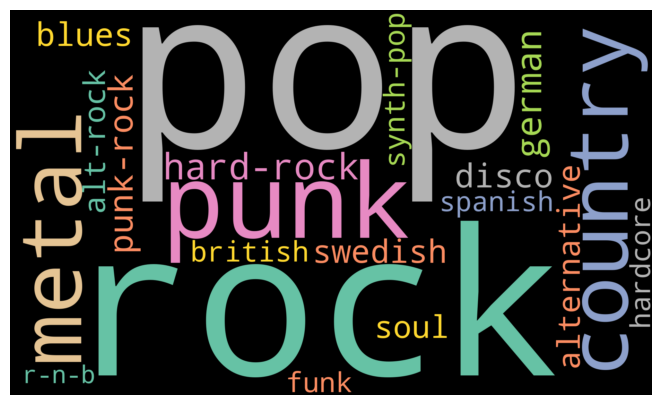

In [973]:
genre_counts = genre_counts.sort_values(by='count', ascending=False)
genre_counts_dict = genre_counts.set_index('genres')['count'].to_dict()
cloud = wordcloud.WordCloud(height = FIG_HEIGHT, width = FIG_WIDTH, background_color='black',colormap='Set2').generate_from_frequencies(genre_counts_dict)
cloud.to_file('top_20_genres.png')
plt.figure(figsize=(10, 5))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Word Cloud for Genres per Year

There are several null values after pivot the dataframe, because some genres doesn't exist in some years. But it doesn't matter for our purpose

In [974]:
genres_by_year = top_genres_per_year.copy()

In [975]:
genres_by_year = genres_by_year.to_dict('index')

In [976]:
def wc(df):
    clear_output(wait=True)
    cloud = wordcloud.WordCloud(width=FIG_WIDTH, height=FIG_HEIGHT, background_color='black').generate_from_frequencies(df)
    plt.figure(figsize=(9, 9))
    plt.imshow(cloud)
    plt.tight_layout()
    plt.axis("off")

In [977]:
dropdown = widgets.Dropdown(options = genres_by_year,
                                value=genres_by_year[1980],
                                 description= "year" )

widgets.interact(wc,df=dropdown)

interactive(children=(Dropdown(description='year', options={1980: {'acoustic': 55, 'afrobeat': 30, 'alt-rock':…

<function __main__.wc(df)>

## Chart power of Artists in Word Cloud

split artists

In [978]:
df_artists = df.copy()
df_artists = df_artists.drop_duplicates(["name","year"])

In [979]:
print('Occurences of substring ", ": ' + str(len(df_artists.loc[df_artists["artists"].str.contains(', ')])))
print('Occurences of substring "_":' + str(len(df_artists.loc[df_artists["artists"].str.contains('_')])))

Occurences of substring ", ": 348
Occurences of substring "_":0


In [980]:
df_artists.loc[df_artists["artists"].str.contains(', '), 'artists'] = df_artists[df_artists["artists"].str.contains(', ')]['artists'].str.replace(', ', '_')

In [981]:
print('Occurences of substring ", ": ' + str(len(df_artists.loc[df_artists["artists"].str.contains(', ')])))
print('Occurences of substring "_":' + str(len(df_artists.loc[df_artists["artists"].str.contains('_')])))

Occurences of substring ", ": 0
Occurences of substring "_":348


In [982]:
df_artists['artists'] = df_artists['artists'].str.split(',')
df_split_artists = df_artists.explode('artists')

In [983]:
print('Occurences of substring ", ": ' + str(len(df_split_artists.loc[df_split_artists["artists"].str.contains(', ')])))
print('Occurences of substring "_":' + str(len(df_split_artists.loc[df_split_artists["artists"].str.contains('_')])))

Occurences of substring ", ": 0
Occurences of substring "_":348


In [984]:
df_split_artists.loc[df_split_artists['artists'].str.contains('_'), 'artists'] = df_split_artists[df_split_artists["artists"].str.contains('_')]['artists'].str.replace('_', ', ')

In [985]:
print('Occurences of substring ", ": ' + str(len(df_split_artists.loc[df_split_artists["artists"].str.contains(', ')])))
print('Occurences of substring "_":' + str(len(df_split_artists.loc[df_split_artists["artists"].str.contains('_')])))

Occurences of substring ", ": 348
Occurences of substring "_":0


In [986]:
df_split_artists["artists"].unique()

array(['akram rahi', 'walid toufic',
       'patricio rey y sus redonditos de ricota', ..., 'ava',
       'fereydun shahbazian', 'mohammad-reza shajarian'], dtype=object)

In [987]:
df_artist_chart_power_per_year = (
    df_split_artists.groupby(['year', 'artists'])
    .agg({'chart_power': 'sum'})
    .groupby('year', as_index=False)
    .apply(lambda group: group.nlargest(15, columns='chart_power'))
    .reset_index(level=0, drop=True)
    .reset_index()
    .pivot(index='year', columns='artists', values='chart_power')
    .fillna(0)
    .astype(float)
    .to_dict(orient='index')
)

In [988]:
dropdown = widgets.Dropdown(options = df_artist_chart_power_per_year,
                                value=df_artist_chart_power_per_year[1980],
                                 description= "year" )

widgets.interact(wc,df=dropdown)

interactive(children=(Dropdown(description='year', options={1980: {'a-ha': 0.0, 'abba': 5044.0, 'ac/dc': 1920.…

<function __main__.wc(df)>

## Chart Power of Artists in Word Cloud (All years)

In [989]:
df_chart_power_artists = df_split_artists.copy()

sum of chart score per artists

In [990]:
df_chart_power_artists = df_chart_power_artists.groupby("artists")["chart_power"].sum().reset_index()

Top 20 Chart Score Artists in Word Cloud

In [991]:
top20_chart = df_chart_power_artists.sort_values(['chart_power'],ascending=False).head(20)

In [992]:
def wordcloud_artists(counts, file=None):
    cloud = wordcloud.WordCloud(width=FIG_WIDTH, height=FIG_HEIGHT, background_color='black').generate_from_frequencies(counts)
    if file:
        cloud.to_file(file)
    plt.figure(figsize=(18,15))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

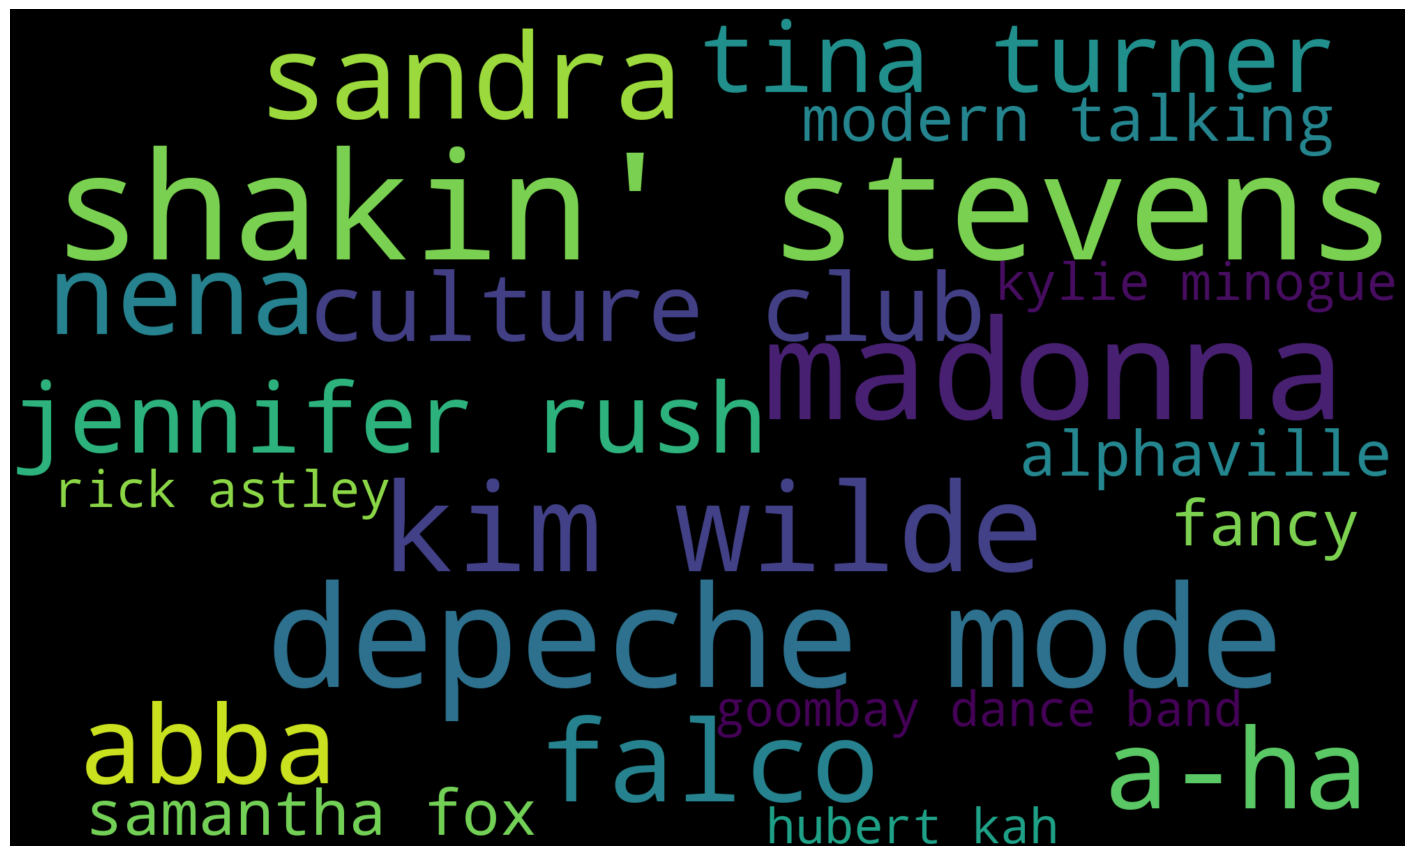

In [993]:
top20_chart_tuples = [tuple(x) for x in top20_chart.values]
wordcloud_artists(dict(top20_chart_tuples), 'top_20_artists_chart_power.png')

## Popularity of Artists in Word Cloud (All years)

In [994]:
df_split_artists.groupby("artists", as_index=False)["popularity"].sum()

,artists,popularity
0,"""colacho"" méndoza y su acordeón",10
1,'om' alec khaoli,1
2,'til tuesday,679
3,*nsync,11
4,000 maniacs,911
...,...,...
14255,趙一豪,1
14256,鈴木一郎,0
14257,黄凤凤,0
14258,黒住憲五,303


Problem: 

In [995]:
df_split_artists.loc[df_split_artists['artists'] == 'johann sebastian bach', 'popularity'].agg(['mean', 'min', 'max'])

mean     1.681905
min      0.000000
max     37.000000
Name: popularity, dtype: float64

In [996]:
df_popularity_artists = df_split_artists.groupby("artists", as_index=False)["popularity"].sum()

In [997]:
top20 = df_popularity_artists.sort_values(['popularity'],ascending=False).head(20)

In [998]:
top20

,artists,popularity
8260,metallica,7786
12797,the smiths,5753
13367,u2,5465
12386,the cure,5436
3833,fleetwood mac,4865
10079,r.e.m.,4731
2848,depeche mode,4660
3194,duran duran,4474
1626,bruce springsteen,4299
12078,talking heads,4128


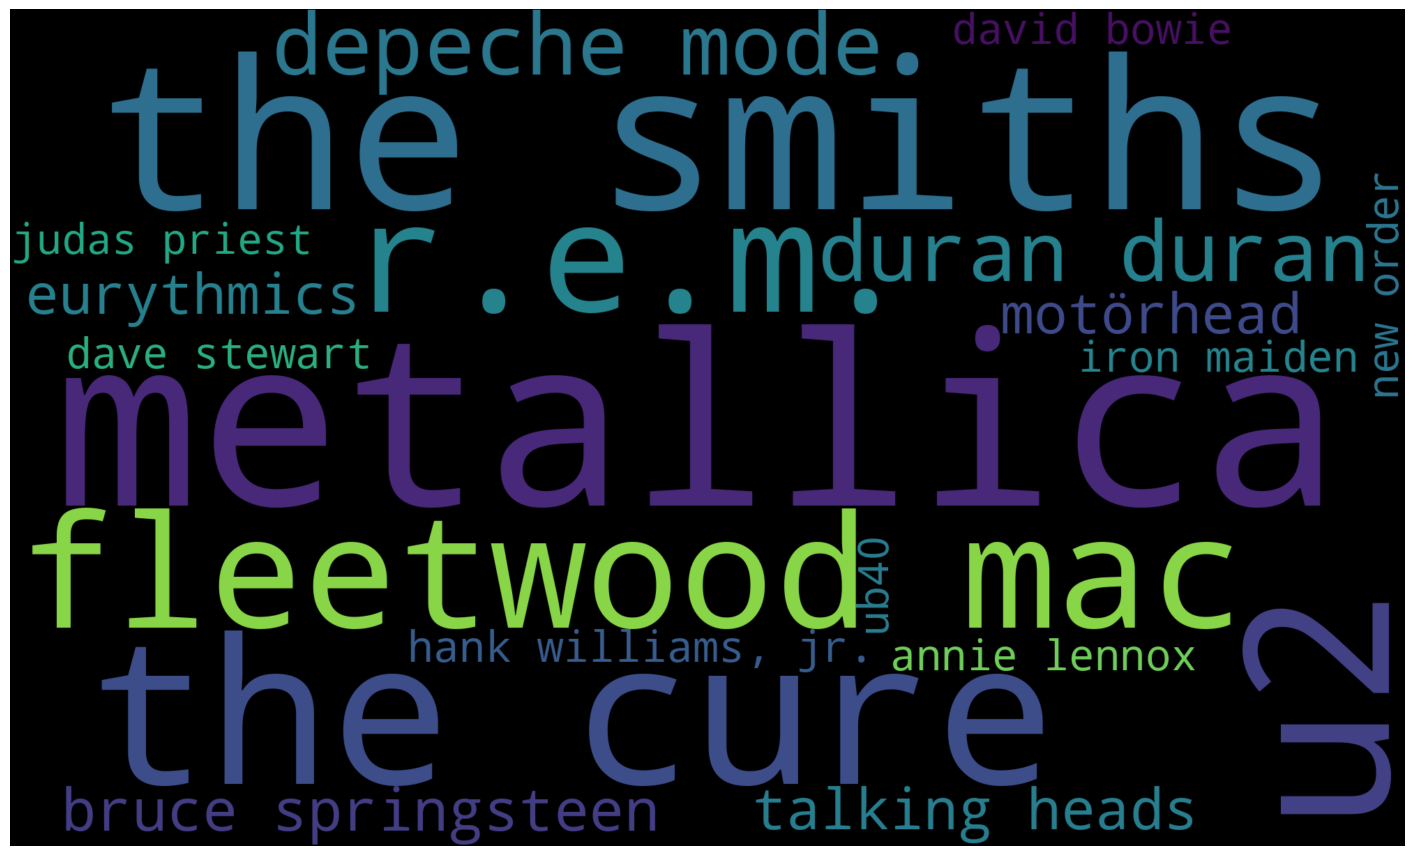

In [999]:
top20_tuples = [tuple(x) for x in top20.values]
wordcloud_artists(dict(top20_tuples), 'top_20_artists_popularity.png')

## Comparison of Chart Power and Popularity for Artists

Merge popularity and chart score

In [1000]:
df_comparison = df_popularity_artists.merge(df_chart_power_artists, on='artists',how="left")
df_comparison['popularity'] = df_comparison['popularity'].fillna(0) #fill nan value to 0
df_comparison['chart_power'] = df_comparison['chart_power'].fillna(0)

In [1001]:
df_comparison.set_index('artists', inplace=True)

In [1002]:
scaler = MinMaxScaler()
df_comparison_sc = pd.DataFrame(
    scaler.fit_transform(df_comparison),
    columns = df_comparison.columns,
    index = df_comparison.index
)

In [1003]:
df_comparison_sc.describe()

,popularity,chart_power
count,14260.000000,14260.000000
mean,0.018276,0.002909
std,0.047512,0.028616
min,0.000000,0.000000
25%,0.000128,0.000000
50%,0.002183,0.000000
75%,0.014513,0.000000
max,1.000000,1.000000


In [1004]:
df_comparison['p_minus_c'] = df_comparison_sc['popularity'] - df_comparison_sc['chart_power']
df_comparison['c_minus_p'] = df_comparison_sc['chart_power'] - df_comparison_sc['popularity']

In [1005]:
df_comparison

,popularity,chart_power,p_minus_c,c_minus_p
artists,,,,
"""colacho"" méndoza y su acordeón",10,0.0,0.001284,-0.001284
'om' alec khaoli,1,0.0,0.000128,-0.000128
'til tuesday,679,0.0,0.087208,-0.087208
*nsync,11,0.0,0.001413,-0.001413
000 maniacs,911,0.0,0.117005,-0.117005
...,...,...,...,...
趙一豪,1,0.0,0.000128,-0.000128
鈴木一郎,0,0.0,0.000000,0.000000
黄凤凤,0,0.0,0.000000,0.000000


In [1006]:
fig = px.scatter(df_comparison, x='popularity', y='chart_power', hover_data=[df_comparison.index])
fig.update_layout(
    font_size=FONT_SIZE,
    height = 500,
    #width = FIG_WIDTH,
    template='plotly_dark',
    title="Chart power vs popularity"
)
fig.show()

### Top 20 popular Artists today vs. in the 80s

In [1007]:
top20_popu = df_comparison.nlargest(20, 'popularity').reset_index()
top20_score = df_comparison.nlargest(20, 'chart_power').reset_index()

In [1008]:
display(top20_popu, top20_score)

,artists,popularity,chart_power,p_minus_c,c_minus_p
0,metallica,7786,0.0,1.000000,-1.000000
1,the smiths,5753,0.0,0.738890,-0.738890
2,u2,5465,919.0,0.642515,-0.642515
3,the cure,5436,0.0,0.698176,-0.698176
4,fleetwood mac,4865,2583.0,0.457925,-0.457925
5,r.e.m.,4731,0.0,0.607629,-0.607629
6,depeche mode,4660,13828.0,-0.295060,0.295060
7,duran duran,4474,5465.0,0.221471,-0.221471
8,bruce springsteen,4299,1927.0,0.427621,-0.427621
9,talking heads,4128,0.0,0.530182,-0.530182


,artists,popularity,chart_power,p_minus_c,c_minus_p
0,shakin' stevens,1947,15475.0,-0.749936,0.749936
1,depeche mode,4660,13828.0,-0.295060,0.295060
2,madonna,2273,13295.0,-0.567193,0.567193
3,kim wilde,2074,10246.0,-0.395725,0.395725
4,sandra,940,9584.0,-0.498592,0.498592
5,falco,1610,8702.0,-0.355545,0.355545
6,nena,1400,8600.0,-0.375925,0.375925
7,a-ha,2994,8365.0,-0.156013,0.156013
8,abba,1737,7989.0,-0.293159,0.293159
9,jennifer rush,973,6949.0,-0.324079,0.324079


In [1009]:
def print_top_20(df_pop, df_chart, y_type, type):
    fig = sp.make_subplots(rows=1, cols=2, subplot_titles=('Top 20 ' + type + ' in the 80s (chart power)', 'Top 20 ' + type + ' at the moment (popularity)'))

    # Add bar trace for top chart score artists
    fig.add_trace(go.Bar(x=df_chart['chart_power'], y=df_chart[y_type],
                         orientation='h', name='Chart Score'), row=1, col=2)
    
    # Add bar trace for top popularity artists
    fig.add_trace(go.Bar(x=df_pop['popularity'], y=df_pop[y_type],
                         orientation='h', name='Popularity'), row=1, col=1)
    
    
    
    # Update layout
    fig.update_layout(#title='Top 20 Artists',
                      font_size=FONT_SIZE,
                      yaxis=dict(autorange="reversed"),
                      yaxis2=dict(autorange="reversed"),
                      width=FIG_WIDTH,  # Width in pixels
                      height=FIG_HEIGHT,
                      template='plotly_dark',
                      xaxis=dict(
                          domain=[0.55 ,1],
                          range=[0, 1.25 * df_pop['popularity'].max()],
                          title="Popularity (acc)"
                          
                      ),
                      xaxis2=dict(
                          domain=[0,0.45],
                          range=[0, 1.25 * df_chart['chart_power'].max()],
                          title="Chart power (acc)"
                      )
                      
    )
    
    # Show the plot
    fig.show()

In [1010]:
print_top_20(top20_popu, top20_score, 'artists', 'artists')

### Top artists that were unpopular in the 80s but are popular today

In [1011]:
def plot_differences(df, x1, range_x1, x2, range_x2, y, title):
    fig = go.Figure()
    
    fig.add_trace(go.Bar(
        x=df[x1],
        y=df[y],
        name=x1,
        orientation='h',
    ))
    
    fig.add_trace(go.Bar(
        x=df[x2],
        y=df[y],
        name=x2,
        orientation='h',
        xaxis='x2', 
    ))
    
    # Set the layout
    fig.update_layout(
        font_size=FONT_SIZE,
        width=FIG_WIDTH,  
        height=FIG_HEIGHT,
        template='plotly_dark',
        barmode='group',
        xaxis=dict(
            title=x1,
            domain=[0,0.5], 
            #autorange='reversed',
            range=range_x1
        ),
        xaxis2=dict(
            title=x2,
            domain=[0.5, 1],  
            range=range_x2
        ),
        yaxis=dict(
            title=y,
            tickmode='array',
            tickvals=df[y],
            ticktext=df[y],
            autorange='reversed'
        ),
        title=title
    )
    
    # Show the plot
    fig.show()

In [1012]:
low_chart_power = df_comparison[df_comparison['chart_power'] < 50]
sorted_low_chart_power = low_chart_power.sort_values(by='popularity', ascending=False)
top_10_low_chart = sorted_low_chart_power.head(10)
top_10_low_chart

,popularity,chart_power,p_minus_c,c_minus_p
artists,,,,
metallica,7786,0.0,1.000000,-1.000000
the smiths,5753,0.0,0.738890,-0.738890
the cure,5436,0.0,0.698176,-0.698176
r.e.m.,4731,0.0,0.607629,-0.607629
talking heads,4128,0.0,0.530182,-0.530182
motörhead,3946,0.0,0.506807,-0.506807
"hank williams, jr.",3935,0.0,0.505394,-0.505394
dave stewart,3788,0.0,0.486514,-0.486514
annie lennox,3788,0.0,0.486514,-0.486514


In [1013]:
top_10_low_chart = df_comparison[df_comparison['chart_power'] < 50].sort_values('p_minus_c', ascending=False)[:10]

In [1014]:
top_10_low_chart.reset_index(inplace=True)

In [1015]:
top_10_low_chart

,artists,popularity,chart_power,p_minus_c,c_minus_p
0,metallica,7786,0.0,1.000000,-1.000000
1,the smiths,5753,0.0,0.738890,-0.738890
2,the cure,5436,0.0,0.698176,-0.698176
3,r.e.m.,4731,0.0,0.607629,-0.607629
4,talking heads,4128,0.0,0.530182,-0.530182
5,motörhead,3946,0.0,0.506807,-0.506807
6,"hank williams, jr.",3935,0.0,0.505394,-0.505394
7,dave stewart,3788,0.0,0.486514,-0.486514
8,annie lennox,3788,0.0,0.486514,-0.486514
9,iron maiden,3778,0.0,0.485230,-0.485230


In [1016]:
cp_max = df_comparison.chart_power.max()
pop_max = df_comparison.popularity.max()
plot_differences(top_10_low_chart, 'chart_power', [cp_max + 1, 0], 'popularity', [0, pop_max], 'artists', 'Top artists with high popularity but low chart power')

### Top artists that were popular in the 80s but are unpopular today

In [1017]:
df_comparison.sort_values('c_minus_p', ascending=False)[:10]

,popularity,chart_power,p_minus_c,c_minus_p
artists,,,,
shakin' stevens,1947,15475.0,-0.749936,0.749936
madonna,2273,13295.0,-0.567193,0.567193
sandra,940,9584.0,-0.498592,0.498592
kim wilde,2074,10246.0,-0.395725,0.395725
nena,1400,8600.0,-0.375925,0.375925
falco,1610,8702.0,-0.355545,0.355545
jennifer rush,973,6949.0,-0.324079,0.324079
hubert kah,560,5717.0,-0.297511,0.297511
depeche mode,4660,13828.0,-0.295060,0.295060


In [1018]:
top_10_low_pop = df_comparison[df_comparison['popularity'] < 500].sort_values('c_minus_p', ascending=False)[:20]
top_10_low_pop.reset_index(inplace=True)

In [1019]:
top_10_low_pop

,artists,popularity,chart_power,p_minus_c,c_minus_p
0,spider murphy gang,311,4501.0,-0.250913,0.250913
1,karat,218,3832.0,-0.219626,0.219626
2,holly johnson,188,3709.0,-0.215531,0.215531
3,inner city,314,3727.0,-0.200511,0.200511
4,neneh cherry,293,3638.0,-0.197457,0.197457
5,visage,463,3864.0,-0.190227,0.190227
6,den harrow,319,3481.0,-0.183972,0.183972
7,chilly,79,2856.0,-0.174409,0.174409
8,p. lion,46,2695.0,-0.168244,0.168244
9,spliff,295,2920.0,-0.150803,0.150803


In [1020]:
cp_max = df_comparison.chart_power.max()
pop_max = df_comparison.popularity.max()
plot_differences(top_10_low_pop, 'chart_power', [cp_max + 1, 0], 'popularity', [0, pop_max], 'artists', 'Top artists with high chart power but low popularity')

## Comparison of Chart Power and Popularity for Songs

Find the most popular songs

In [1021]:
tracks = df[["name","popularity",'chart_power']].copy()
tracks = tracks.sort_values('popularity',ascending=False).drop_duplicates(["name"],keep="first") 
#drop duplicated songs because there are some songs with same name but difference isrc and popularity
#keep only the highest popularity of these songs

In [1022]:
tracks['popularity'] = tracks['popularity'].fillna(0) #fill nan value to 0
tracks['chart_power'] = tracks['chart_power'].fillna(0) #fill nan value to 0

In [1023]:
tracks.set_index('name', inplace=True)

In [1024]:
scaler = MinMaxScaler()
tracks_sc = pd.DataFrame(
    scaler.fit_transform(tracks),
    columns = tracks.columns,
    index = tracks.index
)

In [1025]:
tracks['p_minus_c'] = tracks_sc['popularity'] - tracks_sc['chart_power']
tracks['c_minus_p'] = tracks_sc['chart_power'] - tracks_sc['popularity']

In [1026]:
tracks.reset_index(inplace=True)

In [1027]:
top20_tracks_popularity = tracks.nlargest(20, 'popularity')

Top10 Songs from Chart Score

In [1028]:
top20_tracks_chart = tracks.nlargest(20, 'chart_power')
top20_tracks_chart

,name,popularity,chart_power,p_minus_c,c_minus_p
1087,sun of jamaica,58,3255.0,-0.333333,0.333333
721,johnny and mary,61,3157.0,-0.268743,0.268743
720,skandal im sperrbezirk,61,2617.0,-0.102844,0.102844
219,kids in america,70,2586.0,0.010128,-0.010128
508,fade to grey,64,2518.0,-0.037947,0.037947
34943,down under,19,2488.0,-0.545972,0.545972
779,nur geträumt,60,2479.0,-0.071942,0.071942
139,super trouper,73,2469.0,0.080555,-0.080555
5306,"marie, marie",42,2408.0,-0.257026,0.257026
521,der kommissar,64,2394.0,0.000148,-0.000148


In [1029]:
print_top_20(top20_tracks_popularity, top20_tracks_chart, 'name', 'songs')

#### Top tracks that are popular today but were unpopular in the 80s

All remastered tracks must be filetered out since they do not match the songnames of the chart power dataframe. So they could have a high popularity but they will for sure have a chart power of zero. This will lead to false results and assumptions.

In [1030]:
tracks_comp = tracks[~tracks["name"].str.contains("remaster")]

In [1031]:
top10_tracks_p_minus_c = tracks_comp.sort_values('p_minus_c', ascending=False)[:15]
top10_tracks_p_minus_c

,name,popularity,chart_power,p_minus_c,c_minus_p
2,back in black,85,0.0,0.977011,-0.977011
4,don't stop believin',84,0.0,0.965517,-0.965517
5,welcome to the jungle,84,0.0,0.965517,-0.965517
6,summer of '69,84,0.0,0.965517,-0.965517
10,you give love a bad name,83,0.0,0.954023,-0.954023
12,ahora te puedes marchar,82,0.0,0.942529,-0.942529
14,paradise city,82,0.0,0.942529,-0.942529
20,dancing in the dark,80,0.0,0.919540,-0.919540
21,kickstart my heart,80,0.0,0.919540,-0.919540
25,master of puppets,80,0.0,0.919540,-0.919540


In [1032]:
cp_max = tracks_comp.chart_power.max()
pop_max = tracks_comp.popularity.max()
plot_differences(top10_tracks_p_minus_c, 'chart_power', [cp_max,0], 'popularity', [0,pop_max], 'name', 'Top tracks with low popularity but high chart power')

#### Top tracks that were popular in the 80s but are unpopular today

In [1033]:
top10_tracks_c_minus_p = tracks_comp[tracks_comp['popularity'] < 10].sort_values('c_minus_p', ascending=False)[:15]
top10_tracks_c_minus_p

,name,popularity,chart_power,p_minus_c,c_minus_p
130734,"aloha-oe, until we meet again",1,1574.0,-0.472069,0.472069
85154,heat of the moment,6,1323.0,-0.337486,0.337486
69261,vamos a la playa,9,1376.0,-0.319286,0.319286
82925,maschine brennt,6,1239.0,-0.311680,0.311680
70483,january february,9,1205.0,-0.266751,0.266751
128201,turaluraluralu - ich mach bubu was machst du,1,825.0,-0.241962,0.241962
130550,feuer und flamme,1,809.0,-0.237046,0.237046
101185,child of the universe,3,848.0,-0.226040,0.226040
92927,use it up and wear it out,4,875.0,-0.222840,0.222840
188623,the harder i try,0,645.0,-0.198157,0.198157


In [1034]:
df.drop(index=list(df[df['name'].isna()].index),inplace=True)

In [1035]:
df[["isrc", "name", "popularity"]][df['name'].str.contains('felicita')]

,isrc,name,popularity
8694,BGA261068707,felicita - live,3
23229,DEC158900001,du ferdischer da (felicita) - live,6
150119,SEPQM0610807,felicita,36
167624,USAK60610031,felicitaciones,11


In [1036]:
plot_differences(top10_tracks_c_minus_p, 'chart_power', [cp_max,0], 'popularity', [0,pop_max], 'name', 'Top tracks with high popularity but low chart power')